In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).all()[0][0]

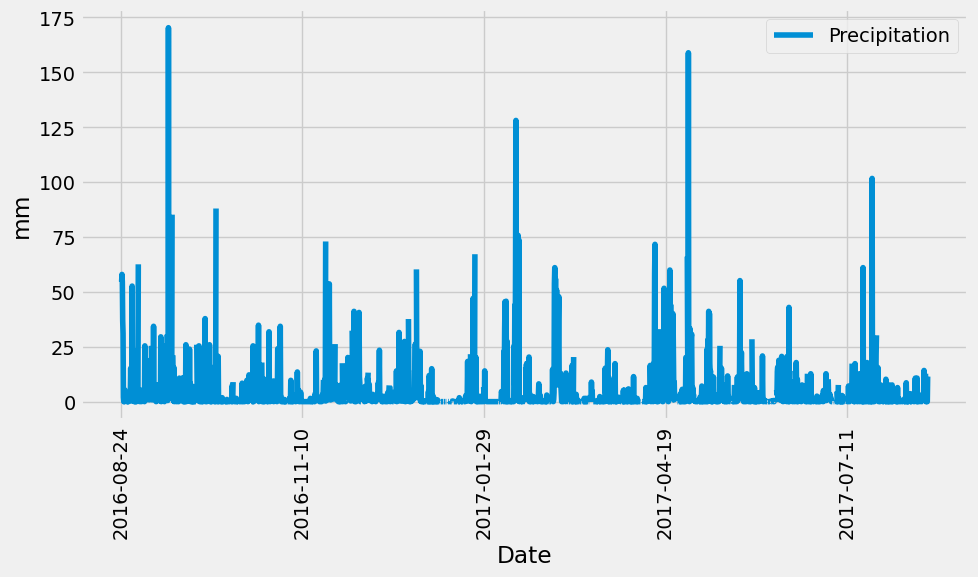

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
start_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_year_query = session.query(measurement.date, measurement.prcp).filter(measurement.date.between(start_date, most_recent_date))

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_query_df = pd.DataFrame(data=last_year_query).set_index('date')

# Sort the dataframe by date
last_year_query_df.sort_values('date', inplace=True)
last_year_query_df.rename(columns = {'prcp': 'Precipitation'}, inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data

last_year_query_df.plot(figsize = (10,6))
plt.xlabel("Date")
plt.ylabel("mm")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


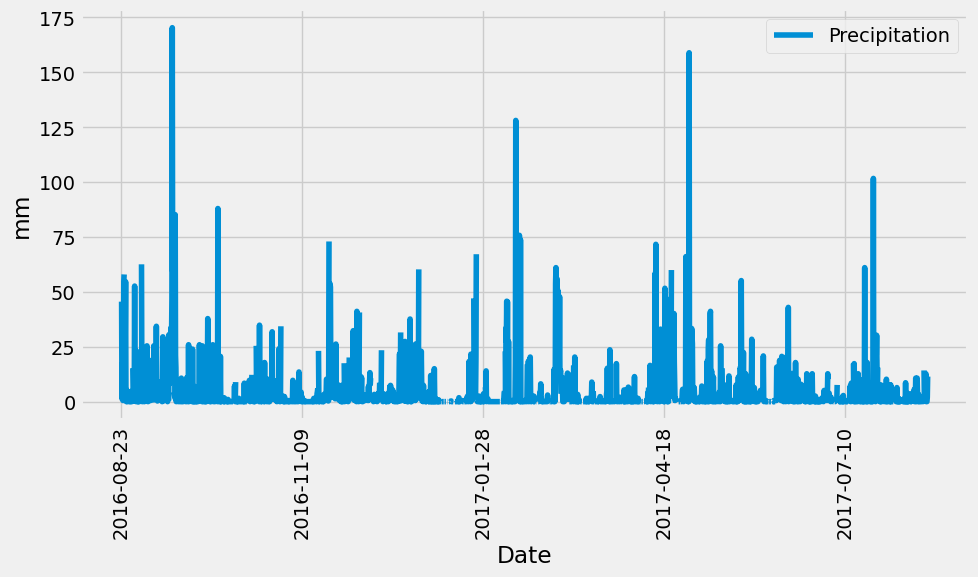

In [13]:
# this is the alternative way of querying the data without passing first date and last date as variables within the filter

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

last_year_wo_var = pd.read_sql("SELECT date, prcp FROM measurement WHERE date <= (SELECT max(date) FROM measurement) AND date >= (SELECT DATE(max(date), '-1 year') FROM measurement)", conn)

last_year_wo_var.set_index('date', inplace=True)

last_year_wo_var.sort_values('date', inplace=True)
last_year_wo_var.rename(columns= {'prcp': 'Precipitation'}, inplace=True)

last_year_wo_var.plot(figsize = (10,6))
plt.xlabel("Date")
plt.ylabel("mm")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_wo_var.describe()

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
session.query(station.station).distinct().count()


9

In [49]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

counter = session.query(measurement.station, station.name, func.count(measurement.station)).group_by(measurement.station).filter(station.station == measurement.station).order_by(func.count(measurement.station).desc()).all()
most_count = counter[0]

print('The following station has the most count:')
print(f'Station: {most_count[0]}')
print(f'Name: {most_count[1]}')
print(f'Count: {most_count[2]}\n')
print(f'The following is the list of stations and their counts in descending order:')
for i in range(len(counter)):
    print(counter[i][0], '-', counter[i][1], '-', counter[i][2])

The following station has the most count:
Station: USC00519281
Name: WAIHEE 837.5, HI US
Count: 2772

The following is the list of stations and their counts in descending order:
USC00519281 - WAIHEE 837.5, HI US - 2772
USC00519397 - WAIKIKI 717.2, HI US - 2724
USC00513117 - KANEOHE 838.1, HI US - 2709
USC00519523 - WAIMANALO EXPERIMENTAL FARM, HI US - 2669
USC00516128 - MANOA LYON ARBO 785.2, HI US - 2612
USC00514830 - KUALOA RANCH HEADQUARTERS 886.9, HI US - 2202
USC00511918 - HONOLULU OBSERVATORY 702.2, HI US - 1979
USC00517948 - PEARL CITY, HI US - 1372
USC00518838 - UPPER WAHIAWA 874.3, HI US - 511


In [55]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == most_count[0]).all()

print(f'The most active station has the following temperature stats:')
print(f'Lowest Temperature: {temp_stats[0][0]}')
print(f'Highest Temperature: {temp_stats[0][1]}')
print(f'Average Temperature: {round(temp_stats[0][2], 1)}')

The most active station has the following temperature stats:
Lowest Temperature: 12.2
Highest Temperature: 29.4
Average Temperature: 22.0


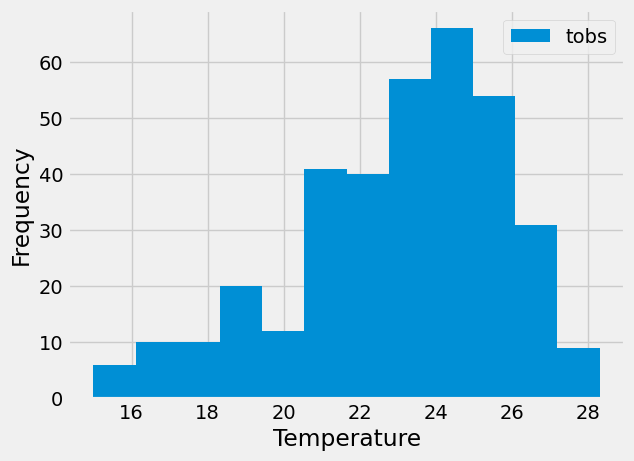

In [71]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_date_1 = session.query(func.max(measurement.date)).filter(measurement.station == most_count[0]).all()[0][0]
start_date_1 = dt.datetime.strptime(most_recent_date_1, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data for the past year
last_year_query_1 = session.query(measurement.tobs, func.count(measurement.date)).\
    filter(measurement.date.between(start_date_1, most_recent_date_1)).filter(measurement.station == most_count[0]).\
    group_by(measurement.date).all()

last_year_query_1_df = pd.DataFrame(data=last_year_query_1, columns=['tobs', 'Frequency'])

plt.hist(last_year_query_1_df['tobs'], 12, label='tobs')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# Close session

In [72]:
# Close Session
session.close()